In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense ,Flatten ,BatchNormalization ,GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam 


In [2]:
train_df = pd.read_csv('styles.csv', usecols=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName'])

In [3]:
train_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
train_df["id"]=train_df["id"].astype(str)
train_df["id"] = train_df["id"].apply(lambda x: x + ".jpg")

In [5]:
train_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970.jpg,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386.jpg,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263.jpg,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379.jpg,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759.jpg,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
train_df['articleType'].nunique()

143

In [7]:
dataset = train_df.groupby('articleType').sample(frac =0.2)

In [8]:
dataset.shape

(8885, 10)

In [9]:
datagen = ImageDataGenerator(
            # rescale=1./255.,
            # width_shift_range=0.2,
            # height_shift_range=0.2,
            # horizontal_flip=True,
            dtype ='float32',
            preprocessing_function=preprocess_input,
            validation_split = 0.30
            )

In [10]:
train_generator = datagen.flow_from_dataframe(
            dataframe=dataset,
            directory="images",
            x_col="id",
            y_col="articleType",
            subset="training",
            batch_size=32,
            shuffle=True,
            color_mode='rgb',
            class_mode="categorical",
            target_size=(224,224))
print('Train generator created')

Found 6219 validated image filenames belonging to 132 classes.
Train generator created


/Users/samuelpradhan/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [11]:
val_generator = datagen.flow_from_dataframe(
            dataframe=dataset,
            directory="images",
            x_col="id",
            y_col="articleType",
            subset="validation",
            batch_size=32,
            shuffle=True,
            class_mode="categorical",
            target_size=(224,224)
)

Found 2664 validated image filenames belonging to 132 classes.


/Users/samuelpradhan/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [13]:
conv_base = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))
conv_base.trainable = False

In [14]:
model=Sequential([
                  conv_base,
                  GlobalMaxPool2D(),
                  Flatten(),
                  Dense(256,activation='relu'),
                  Dense(132,activation='softmax')
])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 132)            │        33,924 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,263,118 (96.37 MB)

 Trainable params: 558,468 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,116,938 (4.26 MB)

In [16]:
model.compile(Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
history=model.fit(train_generator,validation_data=val_generator,epochs=5)

Epoch 1/5


2024-04-05 16:01:01.321815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/samuelpradhan/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


195/195 ━━━━━━━━━━━━━━━━━━━━ 80s 391ms/step - accuracy: 0.5234 - loss: 4.8181 - val_accuracy: 0.0300 - val_loss: 15.5129
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - accuracy: 0.7826 - loss: 0.8332 - val_accuracy: 0.0349 - val_loss: 17.3209
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8286 - loss: 0.5823 - val_accuracy: 0.0387 - val_loss: 20.0222
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - accuracy: 0.8659 - loss: 0.4544 - val_accuracy: 0.0312 - val_loss: 23.6245
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 90s 461ms/step - accuracy: 0.8935 - loss: 0.3298 - val_accuracy: 0.0300 - val_loss: 23.5410


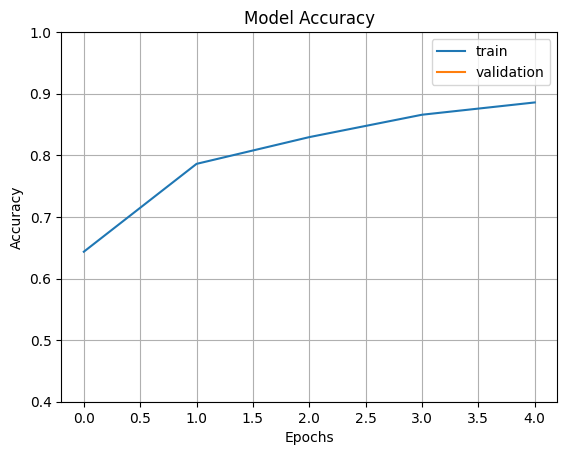

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

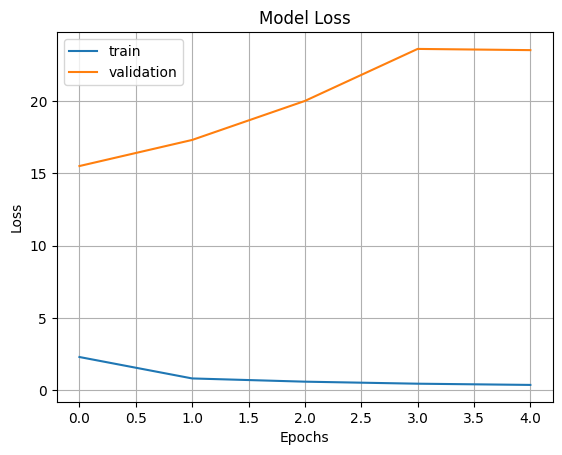

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()